<a href="https://colab.research.google.com/github/ilanmoshe52/Final_Project/blob/main/shaplets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tslearn --ignore-installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 5.9 MB/s eta 0:00:00


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to generate sinusoidal signals with noise
def generate_signal(num_samples, num_sinuses):
    time = np.linspace(0, 2*np.pi, num_samples)
    signal = np.zeros(num_samples)
    for i in range(1,num_sinuses):
        amplitude = np.random.uniform(0.5, 2.5)
        if (i == 1 ):
          frequency = np.random.uniform(0.5, 2.5)
        else:
          frequency = (i+1)*1000*np.random.uniform(0.5, 2.5)

        phase = 0 #np.random.uniform(0, 2*np.pi)
        signal += amplitude * np.sin( frequency * time + phase)
    noise = np.random.normal(0, 0.5, num_samples)  # Additive Gaussian noise
    return signal + noise

# Generate dataset with three classes
num_samples = 32
num_classes = 2
num_signals = 100
X = []
y = []
for i in range(num_classes):
    for j in range(num_signals):
        num_sinuses = i + 1  # Class 1: 1 sinus, Class 2: 2 sinuses, Class 3: 3 sinuses
        signal = generate_signal(num_samples, num_sinuses)
        X.append(signal)
        y.append(i)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to compute the DTW distance between two signals
def dtw_distance(signal1, signal2):
    n = len(signal1)
    m = len(signal2)
    dtw_matrix = np.zeros((n + 1, m + 1))
    dtw_matrix[1:, 0] = np.inf
    dtw_matrix[0, 1:] = np.inf
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(signal1[i - 1] - signal2[j - 1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])
    return dtw_matrix[n, m]

# Function to classify a test signal using DTW
def classify_signal(test_signal, train_signals, train_labels):
    min_distance = np.inf
    predicted_class = None
    for i, train_signal in enumerate(train_signals):
        distance = dtw_distance(test_signal, train_signal)
        #print(distance)
        if distance < min_distance:
            min_distance = distance
            predicted_class = train_labels[i]
    return predicted_class



In [54]:
# Classify test signals and calculate accuracy
correct_predictions = 0
for i in range(len(X_test)):
    predicted_class = classify_signal(X_test[i], X_train, y_train)
    if predicted_class == y_test[i]:
        correct_predictions += 1

accuracy = correct_predictions / len(X_test)
print("Accuracy:", accuracy)


<ipython-input-50-d1e1ac9ae3e4>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])


Accuracy: 0.875


In [53]:
from tslearn.shapelets import ShapeletModel
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax

# Load dataset
#X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

# Initialize shapelet model
shapelet_model = ShapeletModel(n_shapelets_per_size={10: 10},
                               optimizer="adam",
                               weight_regularizer=0.01,
                               )

# Fit the model on training data
shapelet_model.fit(X_train, y_train)

# Evaluate on test data
accuracy = shapelet_model.score(X_test, y_test)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Accuracy: 0.95


In [55]:
X_test.squeeze().shape


(40, 32)

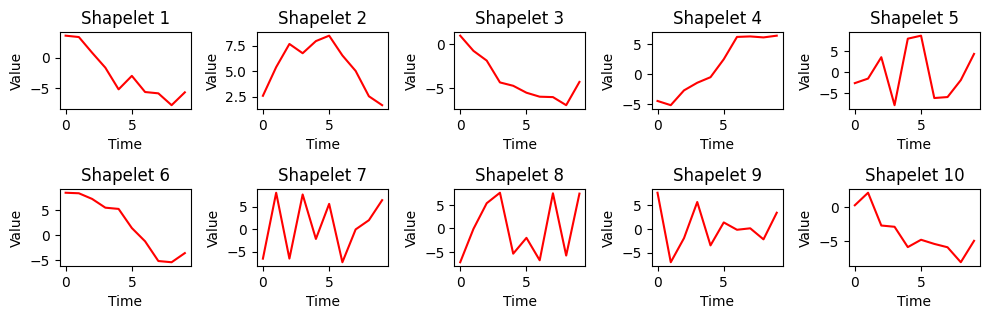

In [56]:
# Extract and plot learned shapelets
plt.figure(figsize=(10, 6))
for i, shapelet in enumerate(shapelet_model.shapelets_):
    plt.subplot(4, 5, i + 1)
    plt.plot(shapelet.ravel(), "r-")
    plt.title("Shapelet {}".format(i + 1))
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [59]:
y_pred = shapelet_model.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])

In [60]:
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.95
